In [1]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [2]:
import pickle
import gensim
data = pickle.load(open("image_vectors.p", "rb"))
word_vector = pickle.load(open("word_vector_min_bird.p", "rb"))
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

11840
11840
Black_Footed_Albatross_0001_796111.jpg
Black_Footed_Albatross_0001_796111.jpg
Black_Footed_Albatross_0002_55.jpg
Black_Footed_Albatross_0003_796136.jpg
Black_Footed_Albatross_0005_796090.jpg
Black_Footed_Albatross_0006_796065.jpg
Black_Footed_Albatross_0007_796138.jpg
Black_Footed_Albatross_0008_796083.jpg
Black_Footed_Albatross_0009_34.jpg


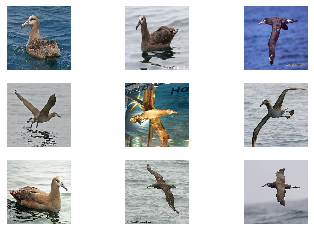

In [3]:

import matplotlib.pyplot as pyplot
from keras.preprocessing.image import array_to_img
from numpy import expand_dims
from random import randint, choice

def random_flip(image):
  image = tf.image.flip_left_right(image)
  return image.numpy()

def random_jitter(image):

  image = expand_dims(image, 0) #add additional dimension necessary for zooming
  image = image_augmentation_generator.flow(image, batch_size=1)
  result = image[0].reshape(image[0].shape[1:]) #remove additional dimension (1, 64, 64, 3) to (64, 64, 3)
  return result

image_augmentation_generator = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.8, 1.0]) # random zoom proves to be helpful in capturing more details https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

n = 227
image_embeddings = []
captions = []
labels = []
for i, k in enumerate(data.keys()):
  image_embeddings.append(data[k])
  captions.append(word_vector[k])
  labels.append(k)
  if i % n == 0:
   image_embeddings.append(random_jitter(data[k]))
   captions.append(word_vector[k])
   labels.append(k)

print(len(captions))
print(len(image_embeddings))

pyplot.axis('off')
slcie = image_embeddings[40:50]
for i in range(9):
  pyplot.subplot(3, 3, i+1)
  pyplot.imshow(array_to_img(slcie[i]))
  print(labels[i])
  pyplot.axis('off')

pyplot.show()

In [4]:
import numpy as np

def get_random_word_vectors_from_dataset(n_samples):
  ix = np.random.randint(0, len(captions), n_samples)
  return np.asarray(captions)[ix]


In [5]:

def generate_random_vectors(n_samples):  
  vectorized_random_captions = []

  for n in range(n_samples):
    rnd = randint(8, 25)
    result_array = np.empty((0, 300))
    for i in range(rnd):
      result_array = np.append(result_array, [model[choice(model.index_to_key)]], axis=0)
    vectorized_random_captions.append(np.mean(result_array, axis=0).astype('float32'))

  return np.array(vectorized_random_captions)


In [6]:
from keras.preprocessing.image import array_to_img

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import asarray
import numpy as np

import os
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from numpy.random import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from numpy.random import randn
from numpy.random import randint
import time
from keras.layers.advanced_activations import PReLU
from tensorflow.keras.utils import plot_model

# Discriminator model
def define_discriminator():
    word_vector_dim = 300
    dropout_prob = 0.4

    in_label = layers.Input(shape=(300,))

    n_nodes = 3 * 64 * 64
    li = layers.Dense(n_nodes)(in_label)
    li = layers.Reshape((64, 64, 3))(li)

    dis_input = layers.Input(shape=(64, 64, 3))

    merge = layers.Concatenate()([dis_input, li])

    discriminator = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same")(merge)
    discriminator = layers.LeakyReLU(0.2)(discriminator)
    discriminator = layers.GaussianNoise(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU()(discriminator)

    discriminator = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same")(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.5)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Flatten()(discriminator)

    discriminator = layers.Dense(1024)(discriminator)

    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Dense(1)(discriminator)

    discriminator_model = Model(inputs=[dis_input, in_label], outputs=discriminator)

    #discriminator_model.summary()

    return discriminator_model


def resnet_block(model, kernel_size, filters, strides):
    gen = model
    model = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.5)(model)
    model = tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(model)
    model = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.5)(model)
    model = layers.Add()([gen, model])
    return model


# Generator model
def define_generator():
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    batch_init = tf.random_normal_initializer(1., 0.02)

    random_input = layers.Input(shape=(100,))
    text_input1 = layers.Input(shape=(300,))
    text_layer1 = layers.Dense(8192)(text_input1)
    text_layer1 = layers.Reshape((8, 8, 128))(text_layer1)

    n_nodes = 128 * 8 * 8
    gen_input_dense = layers.Dense(n_nodes)(random_input)
    generator = layers.Reshape((8, 8, 128))(gen_input_dense)

    merge = layers.Concatenate()([generator, text_layer1])

    model = layers.Conv2D(filters=64, kernel_size=9, strides=1, padding="same")(merge)
    model = tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(model)

    gen_model = model

    for _ in range(4):
      model = resnet_block(model, 3, 64, 1)

    model = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.5)(model)
    model = layers.Add()([gen_model, model])

    model = layers.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Conv2D(3, (3, 3), padding='same', activation='tanh')(model)

    generator_model = Model(inputs=[random_input, text_input1], outputs=model)

    #generator_model.summary()

    return generator_model

In [7]:
g_plot = define_generator()

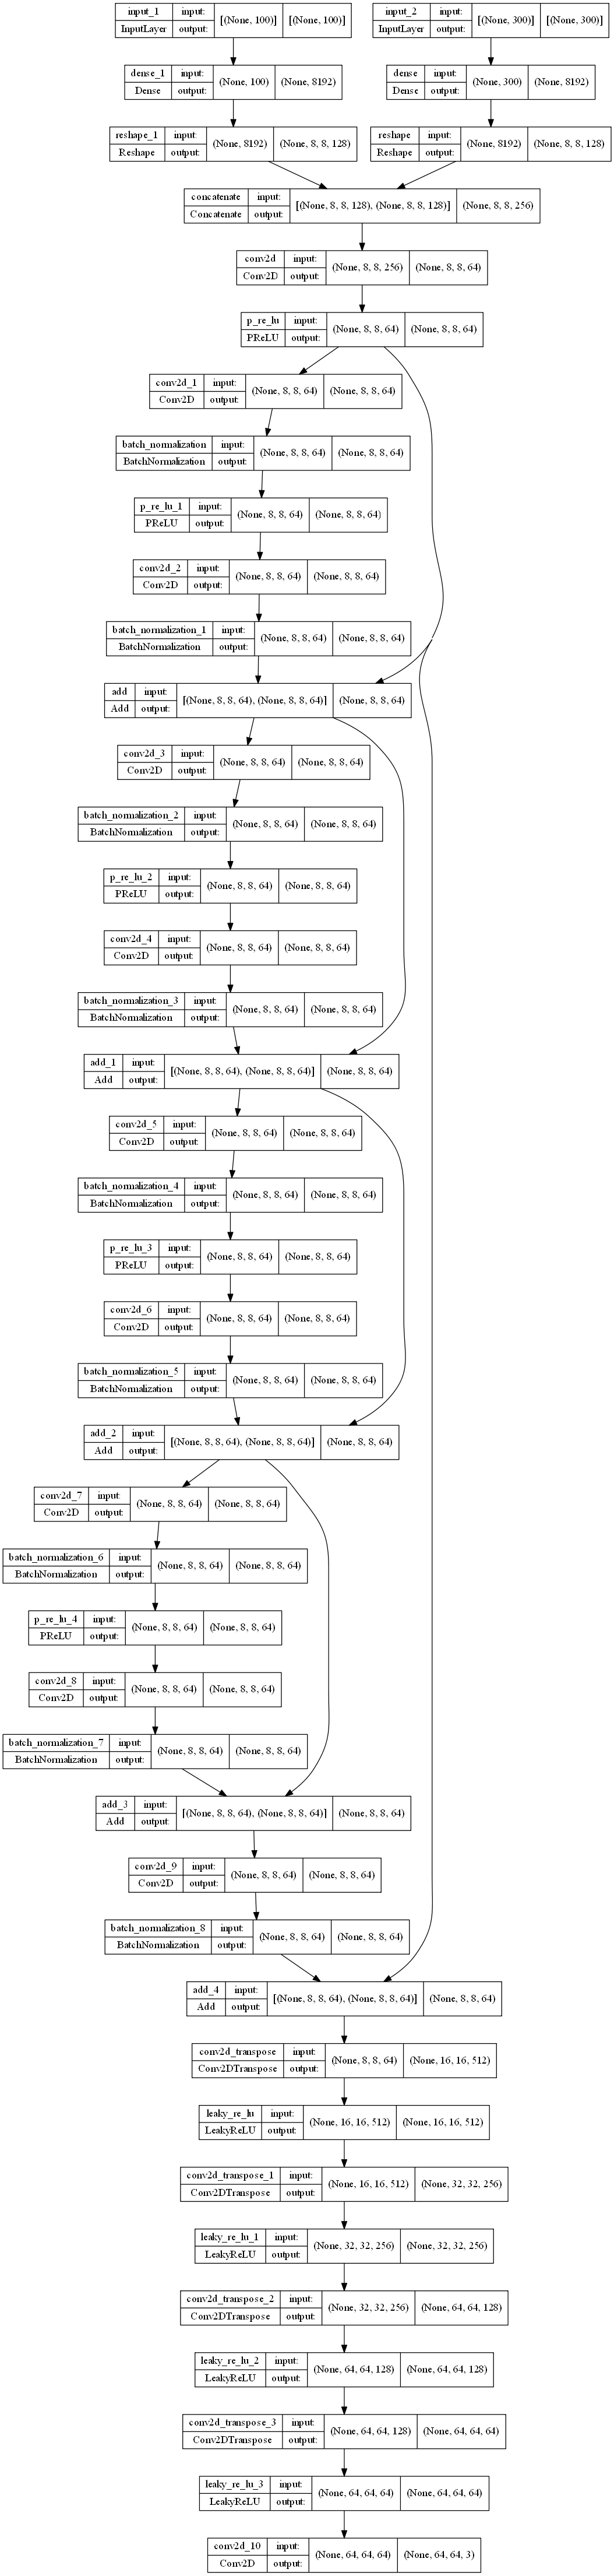

In [8]:
tf.keras.utils.plot_model(g_plot,to_file="gen_model.png",show_shapes=True,dpi=92)

In [11]:
from IPython.display import clear_output


def generate_latent_points(latent_dim, n_samples):
    x_input  = tf.random.normal([n_samples, latent_dim])
    text_captions = get_random_word_vectors_from_dataset(n_samples)
    return [x_input, text_captions]

# Randomly flip some labels. Credits to https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/
def noisy_labels(y, p_flip):
    n_select = int(p_flip * int(y.shape[0]))
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)

    op_list = []
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1.0, y[i]))
        else:
            op_list.append(y[i])

    outputs = tf.stack(op_list)
    return outputs

def load_data():
    return asarray(image_embeddings), asarray(captions).astype('float32')

def smooth_positive_labels(y):
	return y - 0.3 + (np.random.random(y.shape) * 0.5)
 
def smooth_negative_labels(y):
	return y + np.random.random(y.shape) * 0.3

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  print(predictions.shape)
  pyplot.figure(figsize=[7, 7])

  for i in range(predictions.shape[0]):
      pyplot.subplot(5, 5, i+1)
      pyplot.imshow(array_to_img(predictions.numpy()[i]))
      pyplot.axis('off')

  pyplot.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  pyplot.show()


def discriminator_loss(r_real_output_real_text, f_fake_output_real_text_1, f_real_output_fake_text):
   alpha = 0.5
   real_output_noise = smooth_positive_labels(noisy_labels(tf.ones_like(r_real_output_real_text), 0.10))
   fake_output_real_text_noise_1 = smooth_negative_labels(tf.zeros_like(f_fake_output_real_text_1))
   real_output_fake_text_noise = smooth_negative_labels(tf.zeros_like(f_real_output_fake_text))

   real_loss = tf.reduce_mean(binary_cross_entropy(real_output_noise, r_real_output_real_text))
   fake_loss_ms_1 = tf.reduce_mean(binary_cross_entropy(fake_output_real_text_noise_1, f_fake_output_real_text_1))
   fake_loss_2 = tf.reduce_mean(binary_cross_entropy(real_output_fake_text_noise, f_real_output_fake_text))

   total_loss = real_loss + alpha * fake_loss_2 + (1-alpha) * fake_loss_ms_1 
   return total_loss

def generator_loss(f_fake_output_real_text):
   return tf.reduce_mean(binary_cross_entropy(tf.ones_like(f_fake_output_real_text), f_fake_output_real_text))

@tf.function
def train_step(images, epoch):

  #define half_batch
  latent_dim = 100
  n_batch = 32

  noise_1 = tf.random.normal([16, latent_dim])
  noise_2 = tf.random.normal([16, latent_dim])
  real_captions = images[1]
  real_images = images[0]

  random_captions = generate_random_vectors(n_batch)
  random_captions_1, random_captions_2  = tf.split(random_captions, 2, 0)
  real_captions_1, real_captions_2  = tf.split(real_captions, 2 ,0)
  real_images_1, real_images_2 = tf.split(real_images, 2, 0)
  d_loss = 0
  g_loss = 0
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    noise = tf.concat([noise_1, noise_2], 0)

    generated_images = generator([noise, real_captions], training=True)

    fake_1, fake_2 = tf.split(generated_images, 2, 0)

    f_fake_output_real_text_1 = discriminator([fake_1, real_captions_1], training=True)
    f_fake_output_real_text_2 = discriminator([fake_2, real_captions_2], training=True)

    r_real_output_real_text_1 = discriminator([real_images_1, real_captions_1], training=True)
    r_real_output_real_text_2 = discriminator([real_images_2, real_captions_2], training=True)

    f_real_output_fake_text_1 = discriminator([real_images_1, random_captions_1], training=True)
    f_real_output_fake_text_2 = discriminator([real_images_2, random_captions_2], training=True)

    #### Calculating losses ####

    gen_loss = generator_loss(f_fake_output_real_text_1) + generator_loss(f_fake_output_real_text_2) 
    # mode seeking loss
    lz = tf.math.reduce_mean(tf.math.abs(fake_2-fake_1)) / tf.math.reduce_mean(tf.math.abs(noise_2-noise_1))
    eps = 1 * 1e-5
    loss_lz = 1 / (eps+lz) * ms_loss_weight
    total_gen_loss = gen_loss + loss_lz
    g_loss = total_gen_loss
    #if epoch % 10 == 0:
     #   tf.print('G_loss', [total_gen_loss])

    disc_loss_1 = discriminator_loss(r_real_output_real_text_1, f_fake_output_real_text_1, f_real_output_fake_text_1)
    disc_loss_2 = discriminator_loss(r_real_output_real_text_2, f_fake_output_real_text_2, f_real_output_fake_text_2)
    
    total_disc_loss = disc_loss_1 + disc_loss_2
    d_loss = total_disc_loss
        
    

    #### Done calculating losses ####
  if epoch % 10 == 0:
    tf.print('D_loss', [total_disc_loss])
    tf.print('G_loss', [g_loss])
  gradients_of_discriminator = disc_tape.gradient(total_disc_loss, discriminator.trainable_variables)  

  gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.trainable_variables)    

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


from tqdm.notebook import tqdm
def train(dataset, epochs = 2000):

  checkpoint_dir = 'checkpoint'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                  generator=generator,
                                  discriminator=discriminator)
  
  ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
  if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)  #ckpt_manager.checkpoints[3]
    print ('Latest checkpoint restored!!')

  for epoch in tqdm(range(epochs)):
    start = time.time()
    for image_batch in dataset:
        train_step(image_batch, epoch) 

    if (epoch +1) % 10 == 0:
      [z_input, labels_input] = generate_latent_points(100, 25)
      generate_and_save_images(generator,
                            epoch + 1,
                             [z_input, labels_input])

    if (epoch) % 40 == 0:
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

    if (epoch) % 60 == 0:
      generator.save('models/46stage_new_gan_animal_model_%03d.h5' % (epoch + 1))     

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))



In [12]:
ms_loss_weight = 1.0
import tensorflow as tf
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000035, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000035, beta_1 = 0.5)

discriminator = define_discriminator()
generator = define_generator()

images, lbs = load_data()
BUFFER_SIZE = images.shape[0]
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((images,lbs)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train(train_dataset)

Latest checkpoint restored!!


  0%|          | 0/2000 [00:00<?, ?it/s]

D_loss [1.65262532]
G_loss [5.3246274]


KeyboardInterrupt: 

In [ ]:
#
from keras.preprocessing.image import array_to_img

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import asarray
import numpy as np

import os
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from numpy.random import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from numpy.random import randn
from numpy.random import randint
import time
import matplotlib.pyplot as pyplot
from keras.preprocessing.image import array_to_img
from numpy import linspace
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize

from numpy.random import randint
import numpy as np

def create_sent_vector(sent):
  result_array = np.empty((0, 300))

  for word in word_tokenize(sent):
    result_array = np.append(result_array, [model[word]], axis=0)
  final = np.mean(result_array, axis=0).astype('float32')
  return final

def generate_random_word_vectors_from_dataset(n_samples, create_new_captions = False):

  if create_new_captions:
      e = create_sent_vector('This bird has  white breast with brown feathers')
      f = create_sent_vector('This bird has  white breast with blue feathers')
      v = []
      flag = False
      for i in range(n_samples):
        
        if not flag:
          v.append(f)
          flag = True
        elif flag:
          v.append(e)
          flag = False
      return np.asarray(v), np.asarray([])
  else:
    ix = randint(0,len(captions), n_samples)
    print(ix)
    return  np.asarray(captions)[ix], np.asarray(labels)[ix]

def generate_images(model, test_input):

  predictions = model(test_input, training=False)

  print(predictions.shape)
  pyplot.figure(figsize=[15, 15])
  for i in range(predictions.shape[0]):
      pyplot.subplot(1, 9, i+1)
      pyplot.imshow(array_to_img(predictions.numpy()[i]))
      pyplot.axis('off')

  pyplot.show()

# Credit to: https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/
def interpolate_points(p1, p2, n_steps=9):
	ratios = linspace(0, 1, num=n_steps)
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)
 
def generate_latent_points(latent_dim, n_samples, interpolate = False):
    x_input  = tf.random.normal([n_samples, latent_dim])
    text_captions, labels = generate_random_word_vectors_from_dataset(n_samples, create_new_captions=False)
    if interpolate:
      text_captions = interpolate_points(text_captions[0], text_captions[1])
      x_input = interpolate_points(x_input[0], x_input[1])
    for index, s in enumerate(labels.flat):
      print(index, s)

    return [x_input, text_captions]

#gen_model = tf.keras.models.load_model('/content/drive/My Drive/146stage_new_gan_animal_model_120.h5')

for i in range(40):
  generate_images(gen_model, generate_latent_points(100, 9))


In [12]:
train(train_dataset,epochs=1135)

Latest checkpoint restored!!
D_loss [1.67473495]
G_loss [5.06668139]
D_loss [1.56959903]
G_loss [6.49690056]
D_loss [1.61436009]
G_loss [6.51454878]
D_loss [1.5825274]
G_loss [6.22479296]
D_loss [1.55577791]
G_loss [5.84729767]
D_loss [1.58495438]
G_loss [5.80951881]
D_loss [1.54766428]
G_loss [6.27598953]
D_loss [1.54359138]
G_loss [6.10440922]
D_loss [1.57586479]
G_loss [6.54171]
D_loss [1.55873168]
G_loss [6.09861326]
D_loss [1.51981878]
G_loss [7.01540756]
D_loss [1.56870842]
G_loss [5.96083212]


KeyboardInterrupt: 

In [12]:
def get_index_by_label(label):
  for idx, l in enumerate(labels):
    if l in label:
      return idx


print(get_index_by_label('Western_Wood_Pewee_0061_795060.jpg'))

5987


(-0.5, 63.5, 63.5, -0.5)

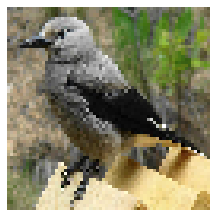

In [13]:
# Show image in image embeddings

pyplot.figure(figsize=[8, 8])

pyplot.subplot(1, 2, 0+1)
pyplot.imshow(array_to_img(image_embeddings[5432]))
pyplot.axis('off')

In [14]:
import tensorflow as tf
gen_model = tf.keras.models.load_model('models/46stage_new_gan_animal_model_781.h5')

In [15]:
import numpy as np
def get_random_word_vectors_from_dataset(n_samples,captions):
    ix = np.random.randint(0, len(captions), n_samples)
    return np.asarray(captions)[ix]

In [16]:
def de7ko(cap):
    f = create_sent_vector(cap)
    v = []
    flag = False
    for i in range(1):    
        v.append(f)
        flag = True
    return np.asarray(v), np.asarray([])

In [17]:
noise = tf.random.normal((1,100))

In [18]:
caption, _ = de7ko('This bird is medium sized has white feather')

In [19]:
print(noise.shape)

(1, 100)


In [20]:
predictions = gen_model([noise,caption], training=False)

In [21]:
predictions.shape

TensorShape([1, 64, 64, 3])

(-0.5, 63.5, 63.5, -0.5)

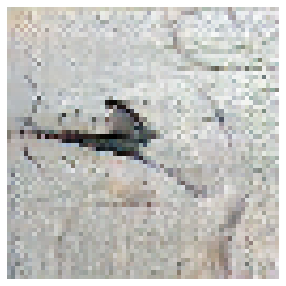

In [22]:
pyplot.figure(figsize=[5, 5])

pyplot.imshow(array_to_img(predictions.numpy()[0]))
pyplot.axis('off')

In [23]:
from gensim.parsing.preprocessing import remove_stopwords

In [24]:
import string

In [25]:
from gensim.parsing.preprocessing import STOPWORDS

all_stopwords_gensim = STOPWORDS.union(set(['a']))

In [26]:
def make_prediction(cap):
    text = cap
    cap = remove_stopwords(text)
    cap = cap.translate(str.maketrans('','', string.punctuation))
    noise = tf.random.normal((1,100))
    
    caption, _ = de7ko(cap)
    predictions = gen_model([noise,caption], training=False)
    pyplot.figure(figsize=[5, 5])
    pyplot.imshow(array_to_img(predictions.numpy()[0]))
    pyplot.axis('off')

In [27]:
def make_prediction_grid(cap):
    pyplot.figure(figsize=[10, 10])

    for i in range(20):
        text = cap
        cap = remove_stopwords(text)
        cap = cap.translate(str.maketrans('','', string.punctuation))
        noise = tf.random.normal((1,100))
    
        caption, _ = de7ko(cap)
        predictions = gen_model([noise,caption], training=False)
    
        pyplot.subplot(5, 5, i+1)
        pyplot.imshow(array_to_img(predictions.numpy()[0]))
        pyplot.axis('off')
    

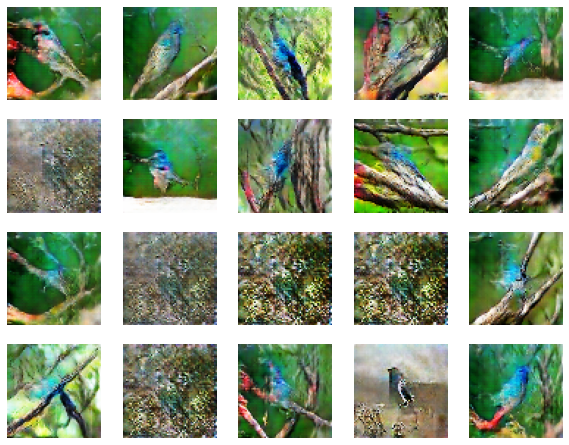

In [38]:
make_prediction_grid('This bird is blue')